# Object Localization with TensorFlow
Project ini merupakan salah satu [Coursera Guided Project](https://www.coursera.org/projects/object-localization-tensorflow) yang telah saya selesaikan.

Dataset yang digunakan pada project ini dibuat oleh [OpenMoji](https://openmoji.org/)

In [1]:
import urllib.request
import zipfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

In [2]:
physical_device = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_device[0], True)

## Download and Visualize Data

In [4]:
data_url_1 = 'https://github.com/hfg-gmuend/openmoji/releases/latest/download/openmoji-72x72-color.zip'
urllib.request.urlretrieve(data_url_1, 'emojis.zip')
local_file = 'emojis.zip'
zip_ref = zipfile.ZipFile(local_file, 'r')
zip_ref.extractall('emojis')

In [6]:
# Dict label emoji
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

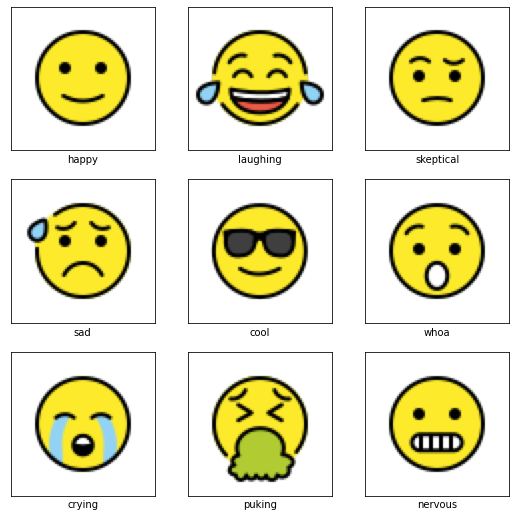

In [7]:
plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Create Examples

In [10]:
def create_example():
    class_id = np.random.randint(0, 9)
    image = np.ones((144, 144, 3)) * 255
    row = np.random.randint(0, 72)
    col = np.random.randint(0, 72)
    image[row: row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])
    return image.astype('uint8'), class_id, (row + 10) / 144, (col + 10) / 144

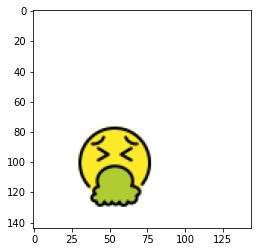

In [13]:
image, class_id, row, col = create_example()
plt.imshow(image)

## Plot Bounding Boxes

In [14]:
def plot_bounding_box(image, gt_coords, pred_coords=[], norm=False):
    if norm:
        image *= 255.
        image = image.astype('uint8')
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)

    row, col = gt_coords
    row *= 144
    col *= 144
    draw.rectangle((col, row, col + 52, row + 52), outline='green', width=3)


    if len(pred_coords) == 2:
        row, col = pred_coords
        row *= 144
        col *= 144
        draw.rectangle((col, row, col + 52, row + 52), outline='red', width=3)

    return image

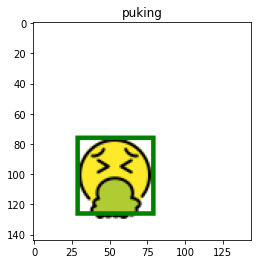

In [15]:
image = plot_bounding_box(image, gt_coords=[row, col])
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

## Data Generator

In [18]:
def data_geneerator(batch_size=16):
    while True:
        x_batch = np.zeros((batch_size, 144, 144, 3))
        y_batch = np.zeros((batch_size, 9))
        bbox_batch = np.zeros((batch_size, 2))
    
        for i in range(0, batch_size):
            image, class_id, row, col = create_example()
            x_batch[i] = image / 255.0
            y_batch[i, class_id] = 1.0
            bbox_batch[i] = np.array([row, col])
        yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch}

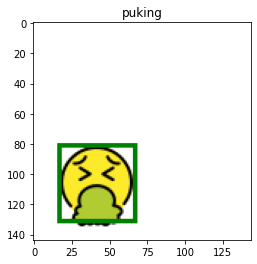

In [19]:
example, label = next(data_geneerator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm=True)
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

## Model

In [21]:
input_ = Input(shape=(144, 144, 3), name='image')

x = input_

for i in range(0, 5):
    n_filters = 2**(4 + i)
    x = Conv2D(n_filters, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

class_out = Dense(9, activation='softmax', name='class_out')(x)
box_out = Dense(2, name='box_out')(x)

model = tf.keras.models.Model(input_, [class_out, box_out])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 144, 144, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 142, 142, 16) 448         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 142, 142, 16) 64          conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 71, 71, 16)   0           batch_normalization_5[0][0]      
____________________________________________________________________________________________

## Custom Metric: IoU

In [22]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IoU, self).__init__(**kwargs)

        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        def get_box(y):
            rows, cols = y[:,0], y[:,1]
            rows, cols = rows * 144, cols * 144
            y1, y2 = rows, rows + 52
            x1, x2 = cols, cols + 52
            return x1, y1, x2, y2
        
        def get_areas(x1, y1, x2, y2):
            return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)

        gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
        p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)

        i_x1 = tf.maximum(gt_x1, p_x1)
        i_y1 = tf.maximum(gt_y1, p_y1)
        i_x2 = tf.minimum(gt_x2, p_x2)
        i_y2 = tf.minimum(gt_y2, p_y2)

        i_area = get_areas(i_x1, i_y1, i_x2, i_y2)
        u_area = get_areas(gt_x1, gt_y1, gt_x2, gt_y2) + get_areas(p_x1, p_y1, p_x1, p_y2) - i_area

        iou = tf.math.divide(i_area, u_area)
        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))
        self.iou = tf.math.divide(self.total_iou, self.num_ex)

    def result(self):
        return self.iou

    def reset_state(self):
        self.io = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

## Compile the Model

In [23]:
model.compile(
    loss={
        'class_out': 'categorical_crossentropy',
        'box_out': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={
        'class_out': 'accuracy',
        'box_out': IoU(name='iou')
    }
)

## Custom Callback

In [24]:
def test_model(model, test_datagen):
    example, label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']

    pred_y, pred_box = model.predict(x)

    pred_coords = pred_box[0]
    gt_coords = box[0]
    pred_class = np.argmax(pred_y[0])
    image = x[0]

    gt = emojis[np.argmax(y[0])]['name']
    pred_class_name = emojis[pred_class]['name']

    image = plot_bounding_box(image, gt_coords, pred_coords, norm=True)
    color = 'green' if gt == pred_class_name else 'red'

    plt.imshow(image)
    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.xticks([])
    plt.yticks([])

In [25]:
def test(model):
    test_datagen = data_geneerator(1)

    plt.figure(figsize=(16, 4))

    for i in range(0, 6):
        plt.subplot(1, 6, i + 1)
        test_model(model, test_datagen)
    plt.show()

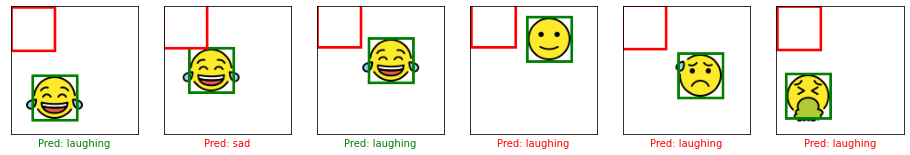

In [26]:
test(model)

In [27]:
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

## Training

Epoch 1/50
500/500 [==============================] - 11s 19ms/step - loss: 2.0043 - class_out_loss: 1.3163 - box_out_loss: 0.6881 - class_out_accuracy: 0.5517 - box_out_iou: 0.3407


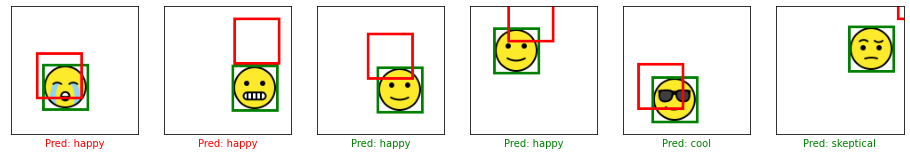

Epoch 2/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0326 - class_out_loss: 0.0089 - box_out_loss: 0.0236 - class_out_accuracy: 1.0000 - box_out_iou: 1.7678


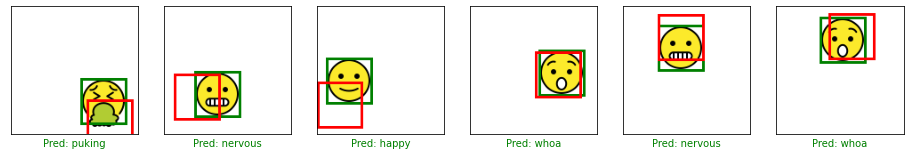

Epoch 3/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0115 - class_out_loss: 0.0025 - box_out_loss: 0.0089 - class_out_accuracy: 1.0000 - box_out_iou: 3.1486


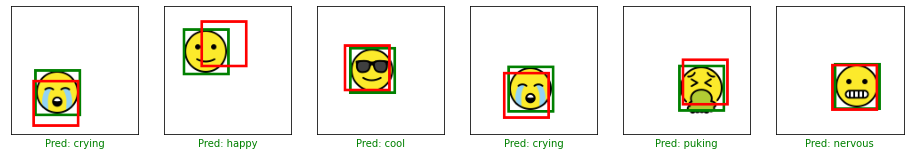

Epoch 4/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0058 - class_out_loss: 9.8366e-04 - box_out_loss: 0.0048 - class_out_accuracy: 1.0000 - box_out_iou: 4.6542


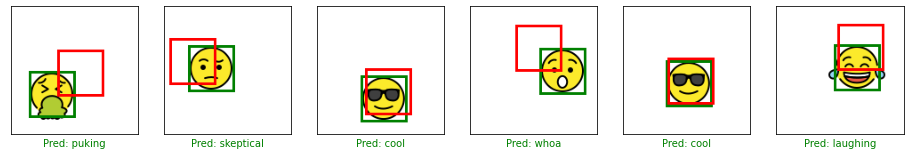

Epoch 5/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0044 - class_out_loss: 0.0013 - box_out_loss: 0.0031 - class_out_accuracy: 1.0000 - box_out_iou: 6.2020


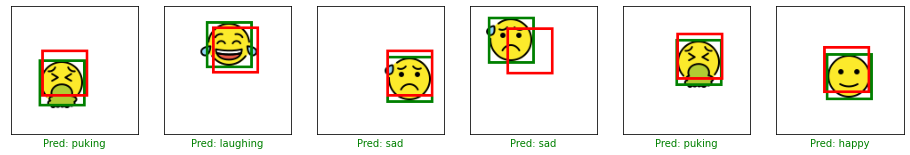

Epoch 6/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0025 - class_out_loss: 5.0401e-04 - box_out_loss: 0.0020 - class_out_accuracy: 1.0000 - box_out_iou: 7.4743


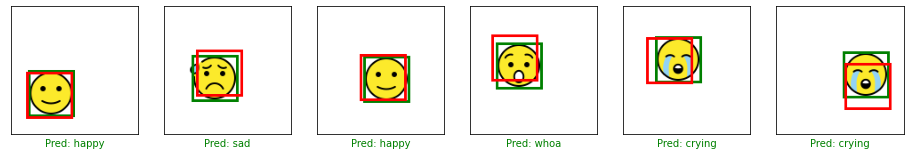

Epoch 7/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0021 - class_out_loss: 3.8670e-04 - box_out_loss: 0.0017 - class_out_accuracy: 1.0000 - box_out_iou: 8.1895


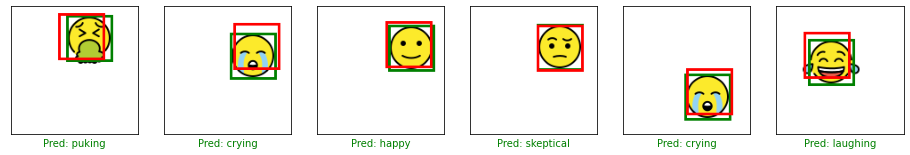

Epoch 8/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0020 - class_out_loss: 3.5655e-04 - box_out_loss: 0.0016 - class_out_accuracy: 1.0000 - box_out_iou: 8.5102


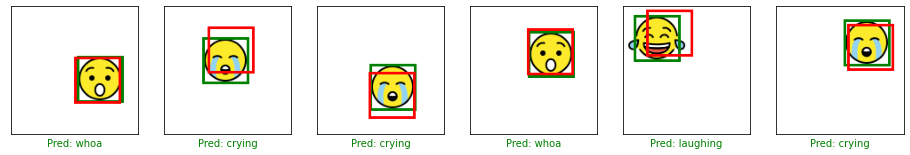

Epoch 9/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0019 - class_out_loss: 3.8750e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 8.6921


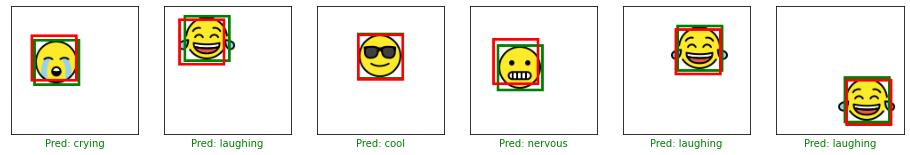

Epoch 10/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0014 - class_out_loss: 3.1542e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 10.4484


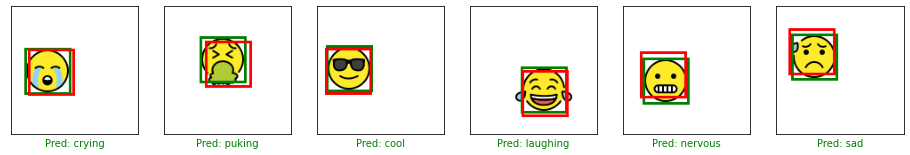

Epoch 11/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0013 - class_out_loss: 3.0086e-04 - box_out_loss: 9.7920e-04 - class_out_accuracy: 1.0000 - box_out_iou: 11.2484


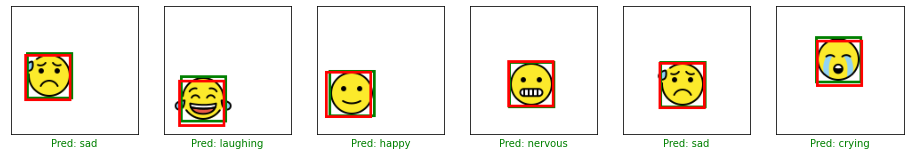

Epoch 12/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0011 - class_out_loss: 2.0183e-04 - box_out_loss: 9.1652e-04 - class_out_accuracy: 1.0000 - box_out_iou: 11.5903


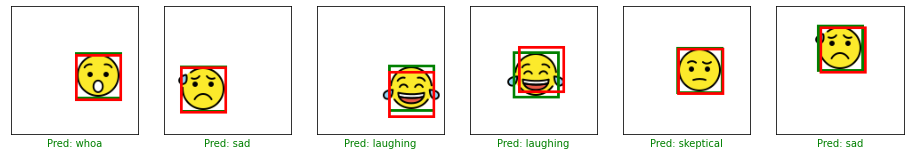

Epoch 13/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0011 - class_out_loss: 2.1300e-04 - box_out_loss: 8.7270e-04 - class_out_accuracy: 1.0000 - box_out_iou: 11.9894


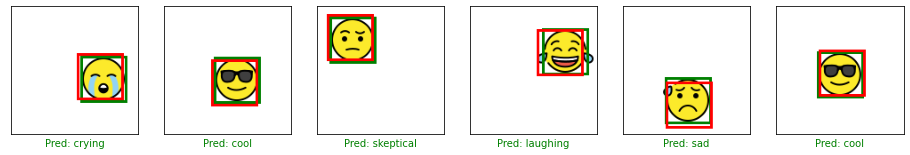

Epoch 14/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0011 - class_out_loss: 2.3526e-04 - box_out_loss: 8.7282e-04 - class_out_accuracy: 1.0000 - box_out_iou: 11.6107: 2s - loss: 0.0011 - class_out_loss: 2.3937e-04 - box_out_loss: 8.7684e-04 - class


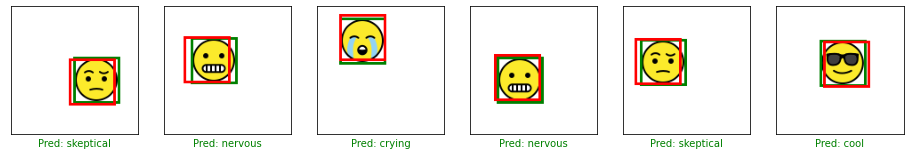

Epoch 15/50
500/500 [==============================] - 9s 18ms/step - loss: 9.5799e-04 - class_out_loss: 1.9226e-04 - box_out_loss: 7.6573e-04 - class_out_accuracy: 1.0000 - box_out_iou: 12.2881


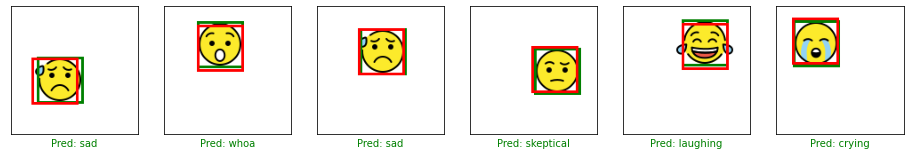

Epoch 16/50
500/500 [==============================] - 9s 18ms/step - loss: 8.8109e-04 - class_out_loss: 1.6133e-04 - box_out_loss: 7.1976e-04 - class_out_accuracy: 1.0000 - box_out_iou: 12.6794


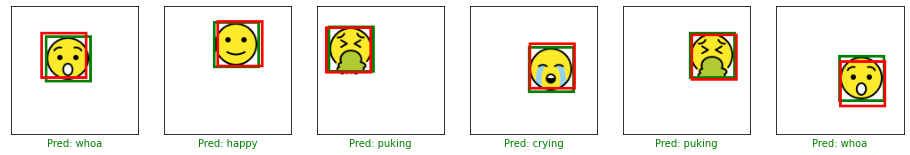

Epoch 17/50
500/500 [==============================] - 9s 18ms/step - loss: 8.7516e-04 - class_out_loss: 1.6598e-04 - box_out_loss: 7.0918e-04 - class_out_accuracy: 1.0000 - box_out_iou: 13.1938


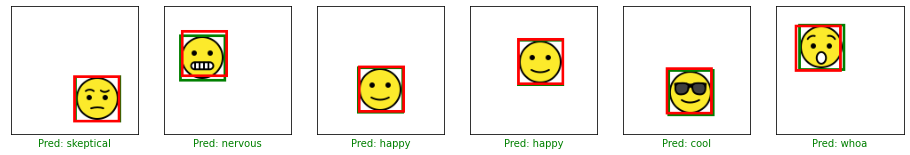

Epoch 18/50
500/500 [==============================] - 9s 18ms/step - loss: 8.6687e-04 - class_out_loss: 1.5632e-04 - box_out_loss: 7.1055e-04 - class_out_accuracy: 1.0000 - box_out_iou: 13.3957


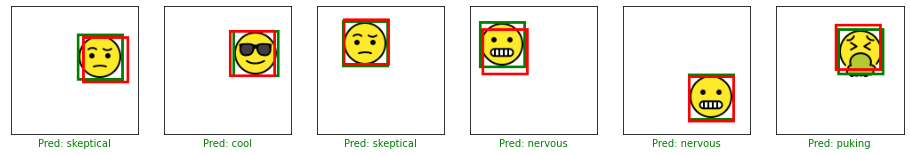

In [28]:
def lr_schedule(epoch, lr):
    if (epoch + 1) % 5 == 0:
        lr *= 0.2
    return max(lr, 3e-7)

_ = model.fit(
    data_geneerator(),
    epochs=50,
    steps_per_epoch=500,
    callbacks=[
               ShowTestImages(),
               tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=3, mode='max'),
               tf.keras.callbacks.LearningRateScheduler(lr_schedule)

    ]
)